In [1]:
import rebound
import numpy as np 
from matplotlib import pyplot as plt

# To render plots inside the Jupyter notebook
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Planets_in_binary_star_systems_-_P-_and_S-type.svg/440px-Planets_in_binary_star_systems_-_P-_and_S-type.svg.png)

Besides exoplanets orbiting single stars, we also find planets in binary star systems. 
We can classify these planets into two two categories:
- *S-type* or *circumprimary* systems where the planet orbits one of the two binary stars
- *P-type* o *circumbinary* systems where the planet's orbit encompasses both stars

Both types of systems are dynamically very interesting because the mass ratio of the two binary stars is much higher 
than that of typical planet orbiting a single star. These systems
also provide a testbed theories of planet formation since it is more challenging to form planets in 
protoplanetary discs warped by a companion star.

The stars in circumbinary systems orbit on very close orbits with periods on the order of tens of
days. Intuitively, the closer a P-type orbit is to the orbit of the binary,
the greater the chance of an interaction with one of the stars. Conversely, 
if the planet is very far away from the binary, it experiences
gravitational forces as if the binary was a single star with a small
gravitational quadropole moment so we expect the dynamics to be similar to that
of regular exoplanets.

For both P and S type  systems the most interesting physics happens when 
planets are close to unstable zones. These systems
pose significant challenges for planet formation theories. Planets can form
in S-type systems if protoplanetary disks form around both of the stars, 
the effect of the gravitational interaction between the two stars is 
to truncate the disks at a certain orbital radius 
If the disk is truncated too close to the star where icy dust grains cannot
form this might hinder or prevent giant planet formation in 
the core accretion scenario.

In this exercise, we'll focus on [circumbinary planets](https://en.wikipedia.org/wiki/Tatooine).
Today, we know of about two dozen or so circumbinary exoplanets, most of which 
were discovered with the transit method using the Kepler space telescope. A particulary famous example is 
[Kepler 16b](http://www.openexoplanetcatalogue.com/planet/Kepler-16%20%28AB%29%20b/), a Saturn
mass planet orbiting a main sequence binary star Kepler 16 with a period of 229 days.
Kepler 16 is located at the very edge of the so called instability zone described in a paper
by [Holman & Wiegert 1998](https://arxiv.org/abs/astro-ph/9809315). 
The instability zone is cause by the overlap of multiple strong [mean
motion resonances](https://arxiv.org/abs/astro-ph/0511710). 

Instead of simulating the dynamics of Kepler 16b directly, we'll explore the orbital
parameter space around the binary star using a scalar 
measure of [chaos](https://en.wikipedia.org/wiki/Chaos_theory)
called the Mean Exponential Growth of Nearby Orbits (MEGNO). 
The three body problem is intrinsically chaotic, this means that phase space trajectories
of in time of a given system are very sensitive to the initial conditions. 
The idea behind various chaos indicators such as the 
[Lyapunov exponent](https://en.wikipedia.org/wiki/Lyapunov_exponent) and MEGNO is to measure
the exponential rate of divergence between two infinitesimally different trajectories as a proxy for chaos.
In other words, if you start with a planetary system with given initial orbital elements, perturb it
ever so slighlty and find that that the evolution of the system changes completely, the system
is likely to be chaotic and therefore also unstable. 

Numerically, the MEGNO is computed by integrating the [variational equations](https://arxiv.org/abs/1603.03424)
for some time. In the case of chaotic orbits, the value of a MEGNO indicator
will grow linearly in time and for quasi-periodic orbits it will tend to 2. 
The relationship between chaotic orbits (high MEGNO) and stability of a system is not straightforward. A system is deemed stable for
a certain time if there are no close encounters between any two bodies
in the system leading to hyperbolic orbits. Chaotic trajectories need
not lead to ejections because the chaos might be bounded. Bounded
chaos means that even if at a certain point in phase space we have exponentially diverging trajectories, the trajectories are still bounded to
a certain finite volume of phase space. Thus, high MEGNO values can
only be used as a proxy for instability.

### Exercises
1. Adapt [this example](https://rebound.readthedocs.io/en/latest/ipython/Megno.html)
of creating a map of MEGNO values in period--eccentricity (instead of semi-major axis-eccentricity)
to the case of the Kepler-16 system. 
The binary period is $P_{bin}=0.1123$ years and the eccentricity is $e_{bin}=0.16$. Use an initial grid which spans the range
$[0, 0.3]$ in eccentricity and $[4P_{bin}, 7P_{bin}]$.
What kind of structure do you see? Try increasing the resolution of the map or exploring a smaller subset of the
parameter space to see finer detail. What happens to the extent of the chaotic zone if you increase the eccentricity
of the binary?
2. Test weather the orbits in the regions of parameter space with large values of MEGNO are unstable by integrating
a planet with the mass of Kepler 16b for some time using `mercurius`.

In [2]:
def simulation(par):
    P, e = par # unpack parameters
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.add(m=0.6897) # Star
    sim.add(m=0.20255, P=0.1123*2*np.pi, e=0.16)
    sim.add(m=0.333, P=P, e=e)
    sim.dt = 0.05*sim.particles[1].P
    sim.move_to_com()

    sim.init_megno()
    sim.exit_max_distance = 20.
    try:
        sim.integrate(5e2*2.*np.pi, exact_finish_time=0) # integrate for 500 years, integrating to the nearest
        #timestep for each output to keep the timestep constant and preserve WHFast's symplectic nature
        megno = sim.calculate_megno()
        return megno
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

In [3]:
Ngrid = 35
P_bin = 0.1123*2*np.pi
par_P = np.linspace(4.*P_bin, 7.*P_bin, Ngrid)
par_e = np.linspace(0., 0.3, Ngrid)
parameters = []
for e in par_e:
    for P in par_P:
        parameters.append((P, e))
from rebound.interruptible_pool import InterruptiblePool
pool = InterruptiblePool()
results = pool.map(simulation,parameters)

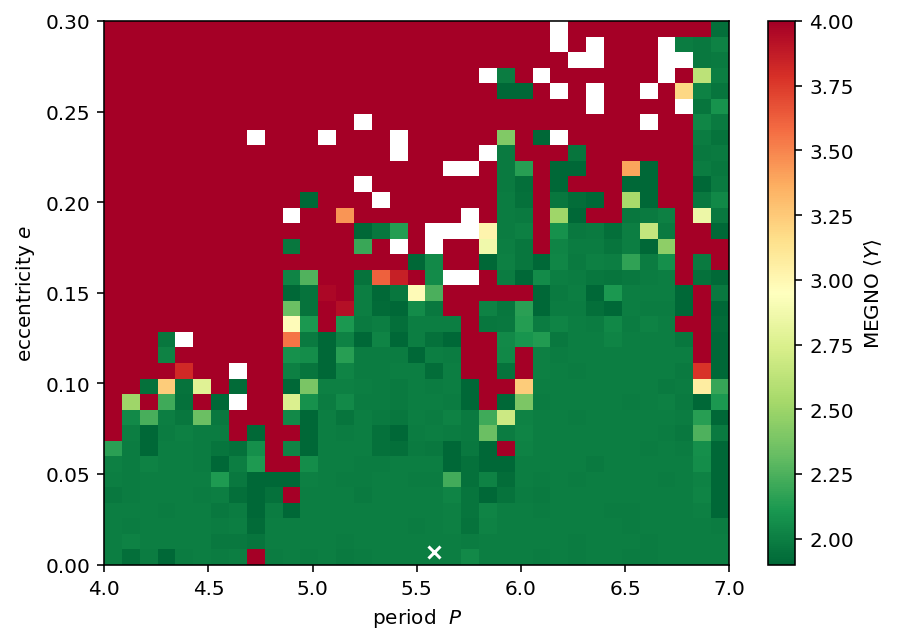

In [4]:
results2d = np.array(results).reshape(Ngrid,Ngrid)

fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(par_P)/P_bin, max(par_P)/P_bin, min(par_e),max(par_e)]
ax.set_xlim(extent[0], extent[1])
ax.set_xlabel("period  $P$")
ax.set_ylim(extent[2], extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(results2d, interpolation="none", vmin=1.9, vmax=4, 
               cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")


# Plot the location of Kepler 16b in this parameter space
ax.scatter((229/365.25)*2*np.pi/P_bin, 0.0069, color='white', marker='x')

Wee see that MEGNO indicates chaotic orbits for $P_p/P_{bin}\gtrapprox 5$ supporting the conclusion of 
Holman & Wiegert (1999). Besides the inner instability zone, we can barely make out instability strips corresponding 
to locations of $N:1$ mean motion resonances, similar to Kirkwood gaps in the solar system. The observed (luckily)
happens to be in between the chaotic regions. Let's check if the orbit near the $6:1$ mean motion resonance
is stable by integrating the orbit of the planet with `whfast`.

In [5]:
sim = rebound.Simulation()

P_bin = 0.1123*2*np.pi

sim.add(m=0.6897) # Star
sim.add(m=0.20255, P=P_bin, e=0.16)
sim.add(m=0.333, P=6.*P_bin, e=0.1, omega=20*np.pi/180, f=30*np.pi/180)

# set timestep to 5% of inner orbital period
sim.dt = 0.05*sim.particles[1].P
sim.integrator = "whfast"

N = 1000
tmax = 1e5*(2*np.pi)
times = np.linspace(0., tmax, N) 

# Initialize empty arrays in which we'll store the orbital elements at each time step
a = np.zeros((2, N))
e = np.zeros((2, N))
inc = np.zeros((2, N))
omega = np.zeros((2, N))

# Iterate over all times in the array and integrate the system forward by dt
for i,t in enumerate(times):
    sim.integrate(t, exact_finish_time=0)
    for j, particle in enumerate(sim.particles[1:]): 
        orbit = particle.calculate_orbit()
        a[j, i] = orbit.a
        e[j, i] = orbit.e
        inc[j, i] = orbit.inc
        omega[j, i] = orbit.omega

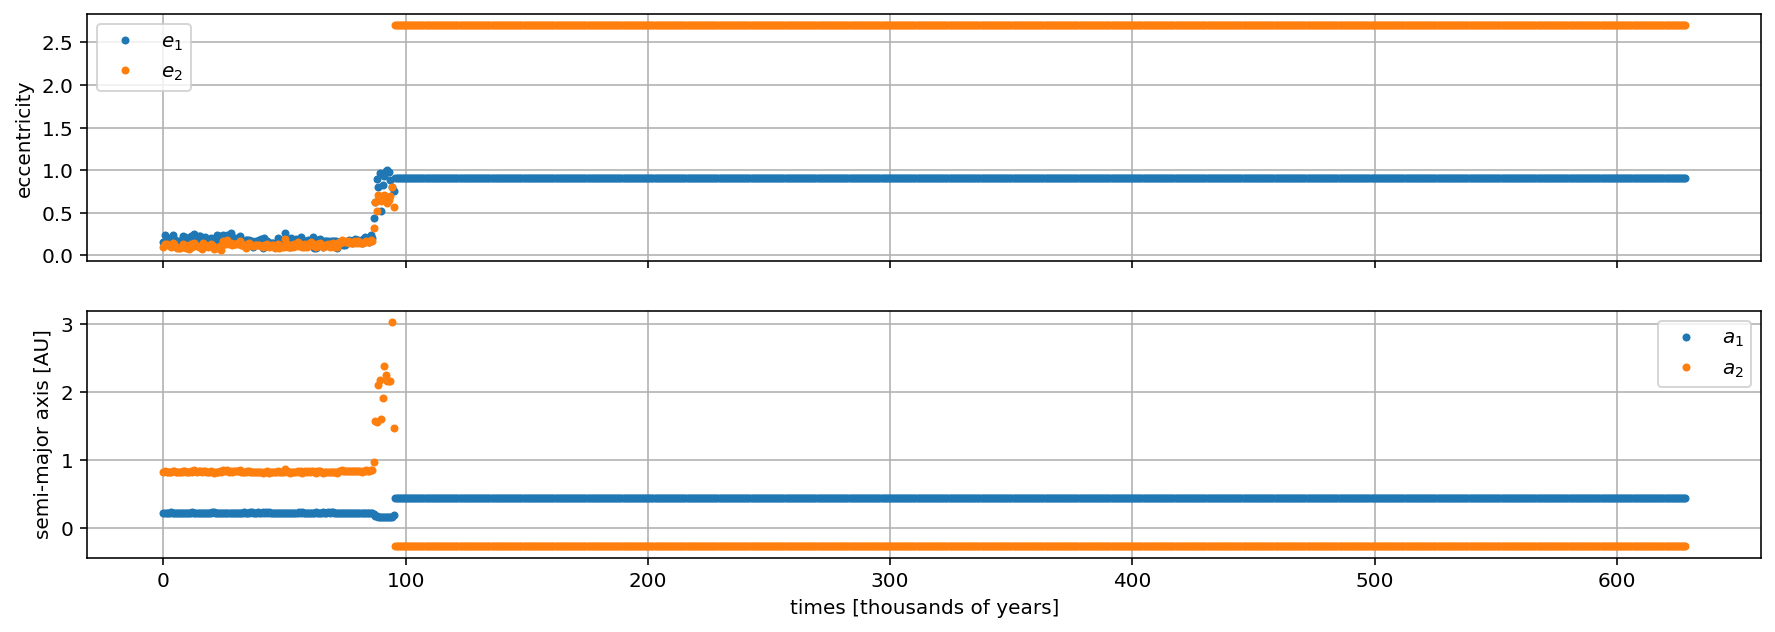

In [6]:
# Plot the relevant orbital elements
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

ax[0].plot(times/1e3, e[0, :], 'C0.', label=r'$e_1$')
ax[0].plot(times/1e3, e[1, :], 'C1.', label=r'$e_2$')
ax[1].plot(times/1e3, a[0, :], 'C0.', label=r'$a_1$')
ax[1].plot(times/1e3, a[1, :], 'C1.', label=r'$a_2$')

ax[1].set_xlabel('times [thousands of years]')
ax[0].set_ylabel('eccentricity')
ax[1].set_ylabel('semi-major axis [AU]')

for a in ax.ravel():
    a.grid()
    a.legend()